In [1]:
import os
os.environ['DATASET_DIR']='/Users/julianquast/Documents/Bachelor Thesis/Datasets/rearrange_10k_v1'


In [2]:
!pip install torch
!pip install einops


import abc
import torch
import numpy as np
from torch.utils.data import Dataset
from typing import Optional, Sequence, List
from torch.utils.data import Dataset, Subset
from torch import default_generator, randperm
from einops import rearrange

In [12]:
from datasets.rearrange_dset import load_rearrange_slice_train_val

datasets, traj_dset = load_rearrange_slice_train_val(
    transform=None,
    n_rollout=5,
    data_path="/Users/julianquast/Documents/Bachelor Thesis/Datasets/rearrange_10k_v1",
    filter_train=True,
    n_slices_train=32,
    filter_val=True,
    n_slices_val=16,
    filter_actions={4, 5},
    seed_train=1337,
    seed_val=123,
    verbose=True
)
sample = datasets['train'][0]
obs, act, state = sample
print('visual shape:', obs['visual'].shape)
print('proprio shape:', obs['proprio'].shape)
print('action shape:', act.shape)
print('state shape:', state.shape)

from torch.utils.data import DataLoader
loader = DataLoader(datasets['train'], batch_size=32)
batch_obs, batch_act, batch_state = next(iter(loader))
print('batch visual shape:', batch_obs['visual'].shape)
print('batch proprio shape:', batch_obs['proprio'].shape)
print('batch action shape:', batch_act.shape)
print('batch state shape:', batch_state.shape)
print( len(batch_obs))

[[2, 4, 3, 0], [1]]
[Filter] Matched: 8 | Non-matched: 565
[Filter] Matched: 2 | Non-matched: 140
visual shape: torch.Size([4, 3, 224, 224])
proprio shape: torch.Size([4, 1])
action shape: torch.Size([4, 1])
state shape: torch.Size([4, 0])
batch visual shape: torch.Size([32, 4, 3, 224, 224])
batch proprio shape: torch.Size([32, 4, 1])
batch action shape: torch.Size([32, 4, 1])
batch state shape: torch.Size([32, 4, 0])
2


Proprioceptive readings:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])

Actions:
 tensor([[2.],
        [2.],
        [5.],
        [0.]])

States:
 tensor([], size=(4, 0))


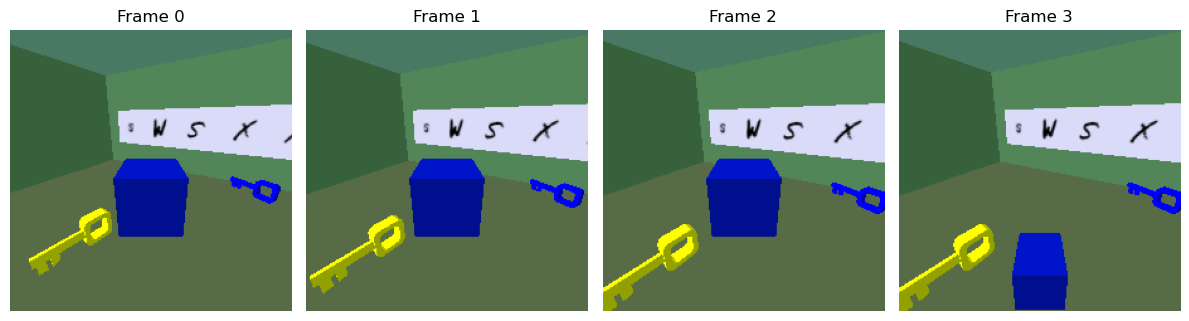


Combined table:
    proprio  action
0      0.0     2.0
1      0.0     2.0
2      0.0     5.0
3      0.0     0.0


In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# — assume you already have obs, act, state from
#     obs, act, state = datasets['train'][0]

# 1) Print out the raw proprio/action/state values:
print("Proprioceptive readings:\n", obs['proprio'])
print("\nActions:\n", act)
print("\nStates:\n", state)

# 2) Visualize the 3 RGB image frames
#    obs['visual'] is a tensor of shape [3, 3, 224, 224]
visual = obs['visual'].cpu().numpy()   # to HWC below

fig, axes = plt.subplots(1, visual.shape[0], figsize=(12, 4))
for i in range(visual.shape[0]):
    img = visual[i].transpose(1, 2, 0)  # C,H,W -> H,W,C
    axes[i].imshow(img)
    axes[i].set_title(f"Frame {i}")
    axes[i].axis("off")
plt.tight_layout()
plt.show()

# 3) Combine proprio, action, state into a small table
df = pd.DataFrame({
    "proprio": obs['proprio'].cpu().numpy().flatten(),
    "action": act.cpu().numpy().flatten(),
    #"state": state.cpu().numpy().flatten()
})
print("\nCombined table:\n", df)


First non-zero action indices: [0, 1, 2, 3, 4]

=== Snippet idx=0 ===
 Actions:
 tensor([[2.],
        [2.],
        [5.],
        [0.]])
 States:
 tensor([], size=(4, 0))
 Proprio:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])


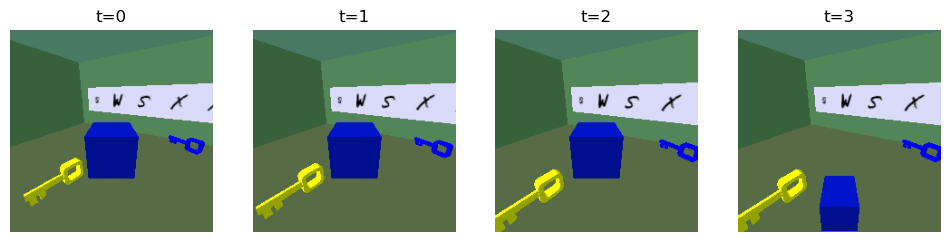


=== Snippet idx=1 ===
 Actions:
 tensor([[2.],
        [2.],
        [5.],
        [0.]])
 States:
 tensor([], size=(4, 0))
 Proprio:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])


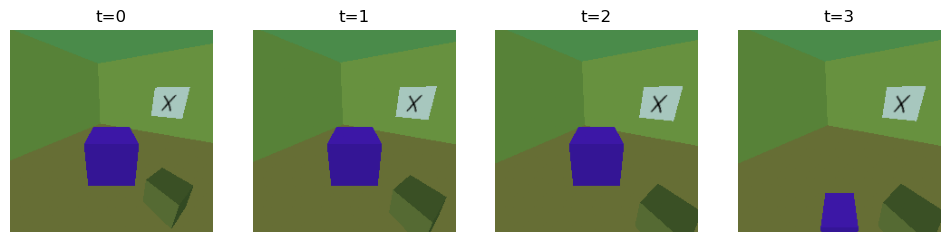


=== Snippet idx=2 ===
 Actions:
 tensor([[2.],
        [2.],
        [4.],
        [0.]])
 States:
 tensor([], size=(4, 0))
 Proprio:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])


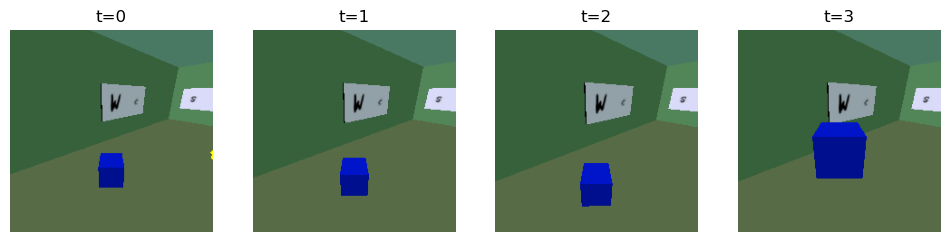


=== Snippet idx=3 ===
 Actions:
 tensor([[2.],
        [2.],
        [5.],
        [0.]])
 States:
 tensor([], size=(4, 0))
 Proprio:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])


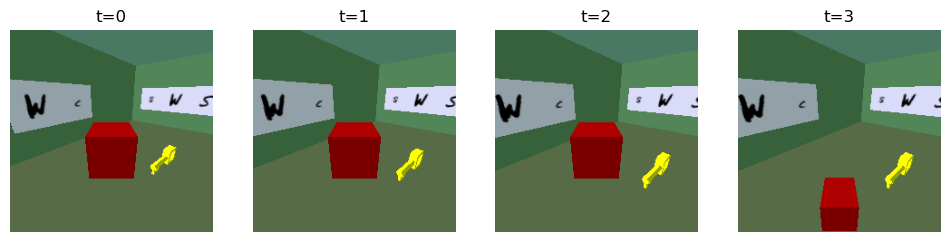


=== Snippet idx=4 ===
 Actions:
 tensor([[2.],
        [2.],
        [4.],
        [1.]])
 States:
 tensor([], size=(4, 0))
 Proprio:
 tensor([[0.],
        [0.],
        [0.],
        [0.]])


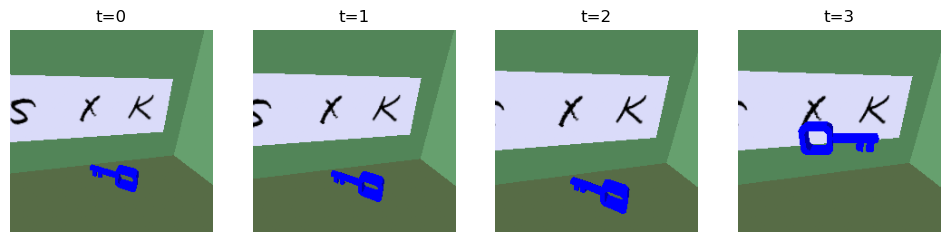

In [14]:
#import matplotlib.pyplot as plt

# 1) Find the first few non-zero snippets
train_ds = datasets['train']
nonzero = []
for idx in range(len(train_ds)):
    _, act, _ = train_ds[idx]
    if act.abs().sum().item() > 0:
        nonzero.append(idx)
    if len(nonzero) >= 5:
        break

print("First non-zero action indices:", nonzero)

# 2) For each, print the actions and plot the 3 frames
for idx in nonzero:
    obs, act, state = train_ds[idx]
    print(f"\n=== Snippet idx={idx} ===")
    print(" Actions:\n", act)
    print(" States:\n", state)
    print(" Proprio:\n", obs['proprio'])

    # Visualize the RGB frames
    visual = obs['visual'].cpu().numpy()  # [3,3,224,224]
    fig, axes = plt.subplots(1, visual.shape[0], figsize=(12,4))
    for t in range(visual.shape[0]):
        img = visual[t].transpose(1,2,0)
        axes[t].imshow(img)
        axes[t].set_title(f"t={t}")
        axes[t].axis("off")
    plt.show()


In [6]:
import random
import torch
from torch.utils.data import Subset

def select_condition_then_sample_rest(dataset, n_slices, target_actions={4, 5}, seed=42, verbose=False):
    """
    Selects all slices where action[-2] ∈ target_actions,
    then adds random samples from the rest until n_slices is reached.
    Seeding ensures reproducibility.

    Args:
        dataset: the dataset to sample from
        n_slices: total number of slices desired
        target_actions: set of action values to select first
        seed: random seed for reproducibility
        verbose: whether to print debug info

    Returns:
        Subset containing n_slices elements
    """
    random.seed(seed)
    torch.manual_seed(seed)

    match_indices = []
    non_match_indices = []

    for idx in range(len(dataset)):
        obs, act, state = dataset[idx]
        if act.shape[0] >= 2:
            last_action = act[-2]
            action_val = int(last_action.item()) if last_action.ndim == 0 else int(last_action[0].item())
            if action_val in target_actions:
                match_indices.append(idx)
            else:
                non_match_indices.append(idx)
        else:
            non_match_indices.append(idx)

    if verbose:
        print(f"Matched: {len(match_indices)}, Non-matched: {len(non_match_indices)}")

    if len(match_indices) > n_slices:
        sampled_indices = random.sample(match_indices, n_slices)
    else:
        n_remaining = n_slices - len(match_indices)
        sampled_rest = random.sample(non_match_indices, min(n_remaining, len(non_match_indices)))
        sampled_indices = match_indices + sampled_rest

    return Subset(dataset, sampled_indices)


def summarize_dataset(dataset, name="Dataset", show_examples=False, max_examples=3):
    import numpy as np
    import torch

    seq_lens = []
    action_vals = []
    visual_shapes = set()
    proprio_shapes = set()
    state_shapes = set()

    for idx in range(len(dataset)):
        obs, act, state = dataset[idx]
        seq_lens.append(act.shape[0])
        
        if act.ndim == 2:
            action_vals.extend(act[:, 0].tolist())  # assumes 1D actions
        else:
            action_vals.extend(act.tolist())

        visual_shapes.add(tuple(obs['visual'].shape))
        proprio_shapes.add(tuple(obs['proprio'].shape))
        state_shapes.add(tuple(state.shape))

    print(f"📊 Summary of {name}")
    print("=" * (20 + len(name)))
    print(f"🟢 Total samples      : {len(dataset)}")
    print(f"📏 Sequence length    : mean={np.mean(seq_lens):.2f}, min={min(seq_lens)}, max={max(seq_lens)}")
    print(f"🎮 Action values      : min={np.min(action_vals)}, max={np.max(action_vals)}, unique={sorted(set(action_vals))}")
    print(f"🖼️  Visual shapes     : {visual_shapes}")
    print(f"💪 Proprio shapes     : {proprio_shapes}")
    print(f"🧠 State shapes       : {state_shapes}")
    
    if show_examples:
        print("\n🔍 Sample examples:")
        for idx in range(min(max_examples, len(dataset))):
            obs, act, state = dataset[idx]
            print(f"  • Sample {idx}:")
            print(f"    - visual: {obs['visual'].shape}")
            print(f"    - proprio: {obs['proprio'].shape}, example: {obs['proprio'][0]}")
            print(f"    - action: {act.shape}, example: {act[-2:]}")
            print(f"    - state: {state.shape}")
